In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the MLB 2023 Standard Batting page
base_url = 'https://www.baseball-reference.com'
main_url = f'{base_url}/leagues/majors/2023-standard-batting.shtml'

# Request the page and parse the HTML content
response = requests.get(main_url)
response.encoding = 'utf-8'  # Set encoding to handle special characters like ñ correctly
soup = BeautifulSoup(response.text, 'html.parser')

# Target the specific div for Player Standard Batting
batting_div = soup.find('div', id='div_players_standard_batting')

# Initialize a dictionary to hold unique player records
unique_players = {}

# Collect all player info that I need
if batting_div:
    for row in batting_div.find_all('tr')[1:]:  # Skip the header row
        player_tag = row.find('td', {'data-stat': 'name_display'})
        age_tag = row.find('td', {'data-stat': 'age'})  # Age column
        team_tag = row.find('td', {'data-stat': 'team_name_abbr'})  # Team abbreviation
        at_bats_tag = row.find('td', {'data-stat': 'b_ab'})  # At-bats column
        home_runs_tag = row.find('td', {'data-stat': 'b_hr'})  # Home Runs column
        slg_tag = row.find('td', {'data-stat': 'b_slugging_perc'})  # Slugging Percentage column
        ba_tag = row.find('td', {'data-stat': 'b_batting_avg'})  # Batting Average column
    
        player_name = player_tag.text.strip('*#')
        age = age_tag.text.strip()
        team_name = team_tag.text.strip()
        at_bats = at_bats_tag.text.strip()
        home_runs = home_runs_tag.text.strip()
        slg_perc = slg_tag.text.strip('.')
        batting_avg = ba_tag.text.strip('.')
             
        if not at_bats or not home_runs or not slg_perc or not batting_avg:
            continue
         
        at_bats = int(at_bats)
        home_runs = int(home_runs)   
        slg_perc = float(slg_perc)/1000.0
        batting_avg = float(batting_avg)/1000.0
        
        if "League Average" in player_name:
           continue
            
        # Create a unique key based on player name and age
        player_key = (player_name, age)
            
            # Add or update the player's record in the dictionary
        if player_key not in unique_players:
            unique_players[player_key] = {
                'Player Name': player_name,
                'Age': age,
                'Team': team_name,
                'At Bats': at_bats,
                'Home Runs': home_runs,
                'Slugging Percentage': slg_perc,
                'Batting Average': batting_avg
            }
        else:
            current_record = unique_players[player_key]
            current_team = current_record['Team']
            current_at_bats = current_record['At Bats']
                
            if current_team != '2TM' and team_name == '2TM':
                unique_players[player_key]['Team'] = team_name
                unique_players[player_key]['At Bats'] = at_bats
                unique_players[player_key]['Home Runs'] = home_runs
                unique_players[player_key]['Slugging Percentage'] = slg_perc
                unique_players[player_key]['Batting Average'] = batting_avg
            elif current_team == '2TM' and team_name == '3TM':
                continue

df_players = pd.DataFrame(unique_players.values())

# Add Home Runs per At-Bat column
df_players['Home Runs per At Bat'] = df_players['Home Runs'] / df_players['At Bats']

# Add Isolated Power column
df_players['Isolated Power'] = df_players['Slugging Percentage'] - df_players['Batting Average']

# Reoder colums
df_players = df_players.loc[:,['Player Name','Age','Team', 'At Bats', 'Home Runs', 'Home Runs per At Bat', 'Slugging Percentage', 'Batting Average', 'Isolated Power']]

# Sort by 'At Bats' in descending order and select the top 200
top_200_players = df_players.sort_values(by='At Bats', ascending=False).head(200)
top_200_players.to_csv('baseball data.csv') 
top_200_players


,Player Name,Age,Team,At Bats,Home Runs,Home Runs per At Bat,Slugging Percentage,Batting Average,Isolated Power
0,Marcus Semien,32,TEX,670,29,0.043284,0.478,0.276,0.202
9,Julio Rodríguez,22,SEA,654,32,0.048930,0.485,0.275,0.210
1,Ronald Acuña Jr.,25,ATL,643,41,0.063764,0.596,0.337,0.259
12,Bobby Witt Jr.,23,KCR,641,30,0.046802,0.495,0.276,0.219
16,Trea Turner,30,PHI,639,26,0.040689,0.459,0.266,0.193
...,...,...,...,...,...,...,...,...,...
206,Matt McLain,23,CIN,365,16,0.043836,0.507,0.290,0.217
203,Yasmani Grandal,34,CHW,363,8,0.022039,0.339,0.234,0.105
200,Martín Maldonado,36,HOU,362,15,0.041436,0.348,0.191,0.157
205,Ramón Laureano,28,2TM,361,9,0.024931,0.371,0.224,0.147


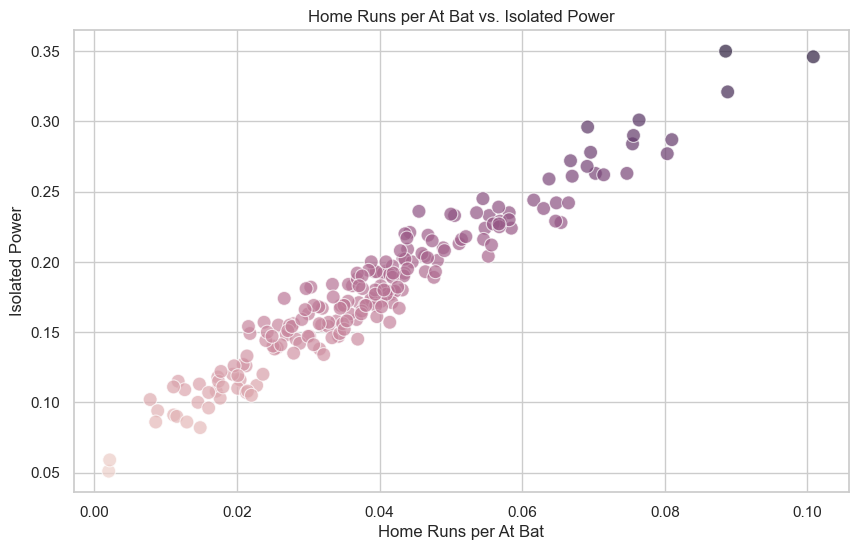

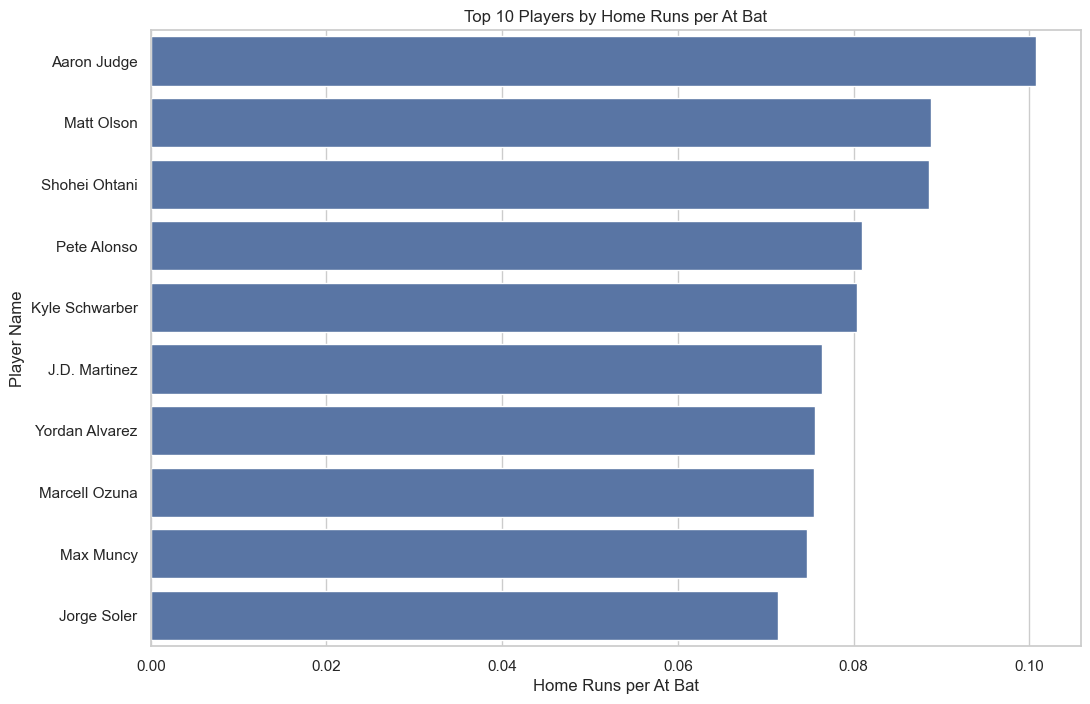

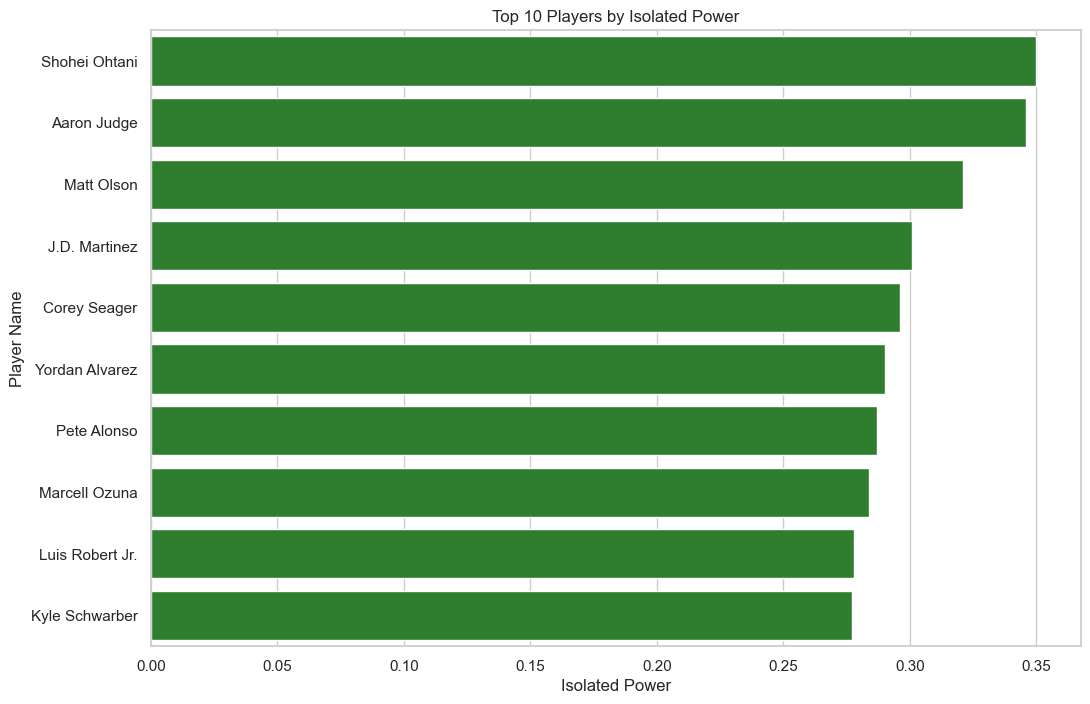

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set plot style for consistency
sns.set_theme(style='whitegrid')

# Scatter plot of Home Runs per At Bat vs. Isolated Power
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top_200_players,
    x='Home Runs per At Bat',
    y='Isolated Power',
    hue='Isolated Power',  # Color by 'Isolated Power'
    legend=False,
    s=100, alpha=0.7
)
plt.title('Home Runs per At Bat vs. Isolated Power')
plt.xlabel('Home Runs per At Bat')
plt.ylabel('Isolated Power')
plt.show()

# Top 10 Players by Home Runs per At Bat
top_power_efficiency = top_200_players.sort_values(by='Home Runs per At Bat', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_power_efficiency, x='Home Runs per At Bat', y='Player Name')
plt.title('Top 10 Players by Home Runs per At Bat')
plt.xlabel('Home Runs per At Bat')
plt.ylabel('Player Name')
plt.show()

# Top 10 Players by Isolated Power
top_pure_power = top_200_players.sort_values(by='Isolated Power', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_pure_power, x='Isolated Power', y='Player Name', color='forestgreen')
plt.title('Top 10 Players by Isolated Power')
plt.xlabel('Isolated Power')
plt.ylabel('Player Name')
plt.show()